# Assignment 2 | Image Classification, December 2021

- [Artificial Neural Networks and Deep Learning 2021 - Homework 2](https://codalab.lisn.upsaclay.fr/competitions/621)

## Three convolutioneers

- *Aleksandra Krajnovic*
- *Iva Milojkovic*
- *Mariusz Wiśniewski*

### Import libraries

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

plt.rc('font', size=16)
import warnings

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Utility function to create folders and callbacks for training

In [3]:
# Utility function to create folders and callbacks for training
from datetime import datetime


def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, 'cp'),
        save_weights_only=False,
        save_best_only=False)
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    return callbacks

### Exploration Data Analysis (EDA)


Load the dataset

In [4]:
dataset = pd.read_csv('/kaggle/input/multivariatetimeseries/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


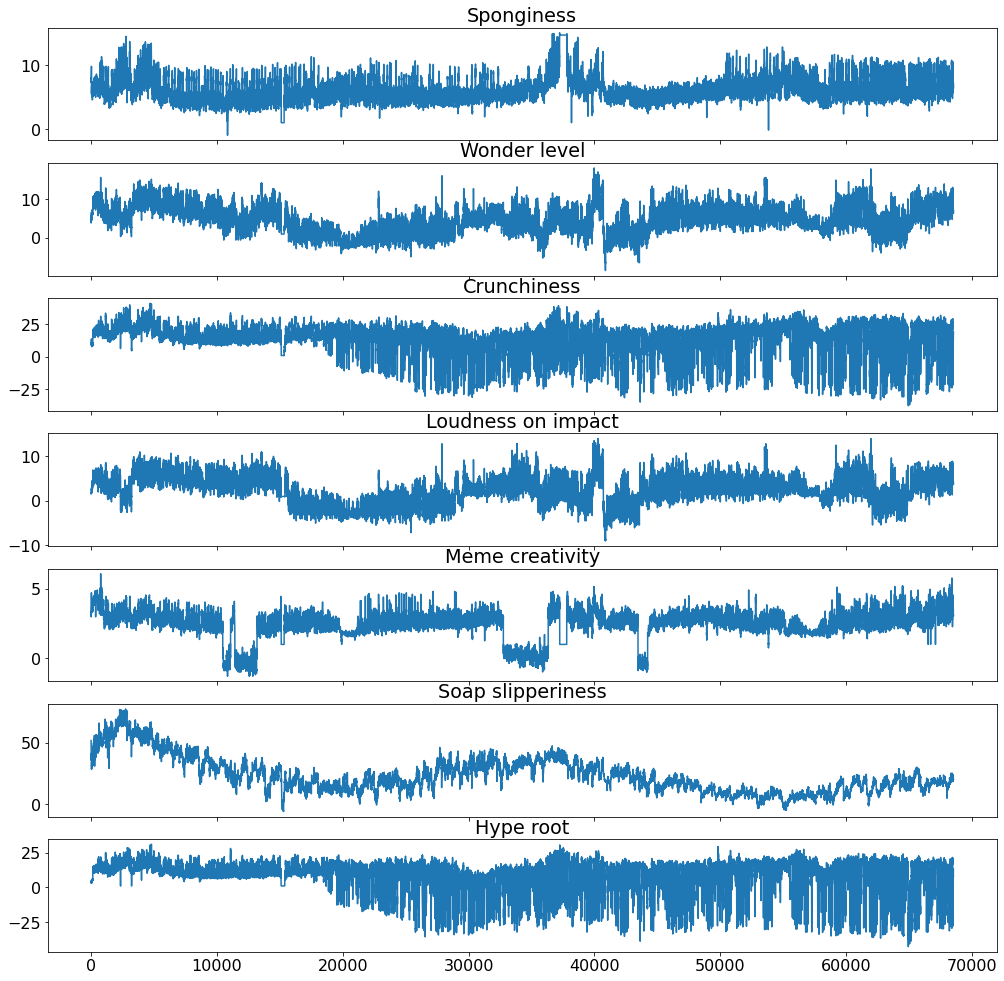

In [6]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()


inspect_dataframe(dataset, dataset.columns)

Normalization

(68528, 7)
       Sponginess  Wonder level  Crunchiness  Loudness on impact  \
0         7.97698       4.33494    10.672820             1.76692   
1         8.07824       4.44616    10.561600             1.70716   
2         8.02844       4.22372    10.561600             1.64906   
3         8.02844       4.22372    10.561600             1.70716   
4         7.87572       4.44616    10.450380             1.70716   
...           ...           ...          ...                 ...   
68523     6.30868       6.33690    15.342401             4.24364   
68524     6.40994       6.55934    16.343380             3.77220   
68525     6.76352       7.00422    17.233140             3.94982   
68526     6.86478       6.67056    17.900460             3.94982   
68527     7.16856       7.11544    19.235099             4.12578   

       Meme creativity  Soap slipperiness  Hype root  
0              3.22440          51.681460    3.65434  
1              3.32566          51.563598    3.47672  
2      

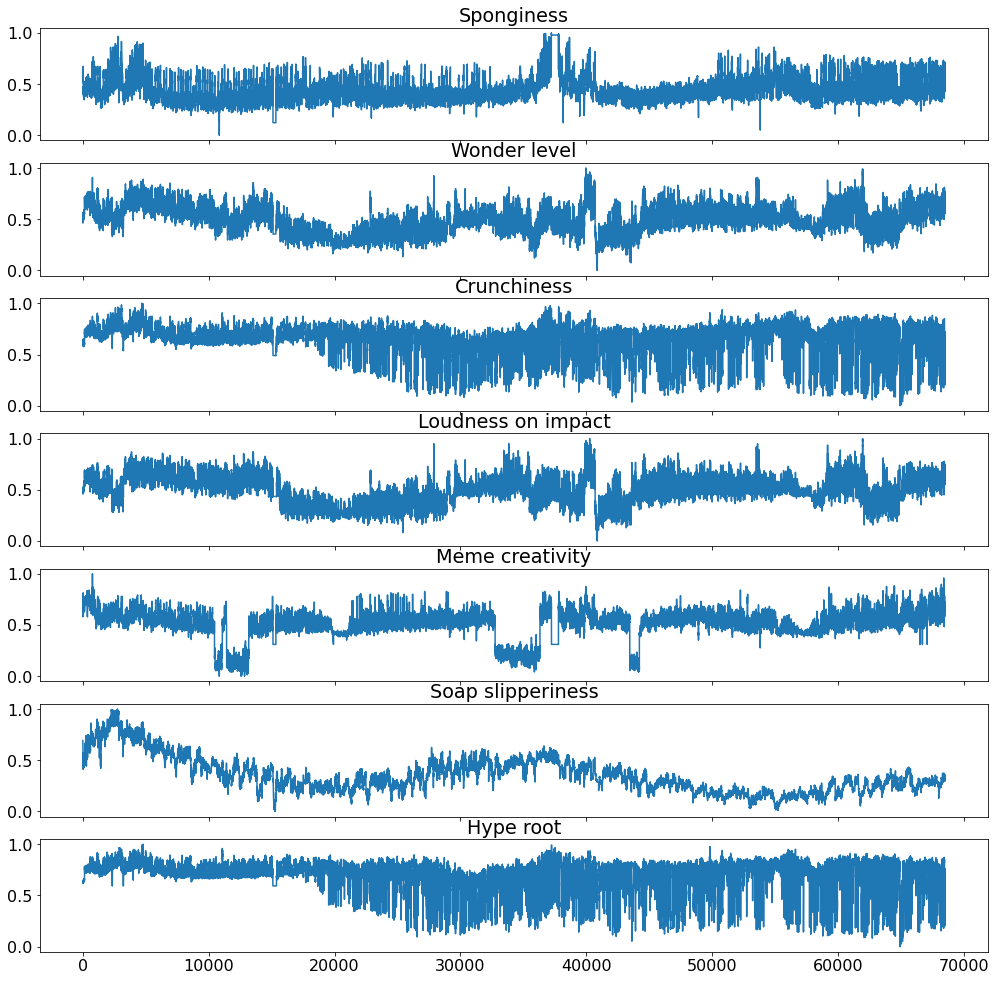

In [7]:
# Data normalization

X_train_raw = dataset
X_min = X_train_raw.min()
X_max = X_train_raw.max()
X_train_raw = (X_train_raw - X_min) / (X_max - X_min)

print(X_train_raw.shape)
print(dataset)

# Plot dataset after normalization
inspect_dataframe(X_train_raw, X_train_raw.columns)

In [8]:
window = 1600
stride = 100

In [9]:
future = dataset[-window:]
future = (future - X_min) / (X_max - X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 1600, 7)

In [10]:
def build_sequences(df, p_target_labels=dataset.columns, p_window=1600, p_stride=100, p_telescope=864):
    # Sanity check to avoid runtime errors
    assert p_window % p_stride == 0
    ds = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[p_target_labels].copy().values
    padding_len = len(df) % p_window

    if padding_len != 0:
        # Compute padding length
        padding_len = p_window - len(df) % p_window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float32')  # Change to float32
        temp_df = np.concatenate((padding, df))
        padding = np.zeros((padding_len, temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding, temp_label))
        assert len(temp_df) % p_window == 0

    for idx in np.arange(0, len(temp_df) - p_window - p_telescope, p_stride):
        ds.append(temp_df[idx:idx + p_window])
        labels.append(temp_label[idx + p_window:idx + p_window + p_telescope])

    ds = np.array(ds)
    labels = np.array(labels)
    return ds, labels

### Multivariate Forecasting (Direct)

In [11]:
target_labels = dataset.columns
telescope = 864

In [12]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
# X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape

((664, 1600, 7), (664, 864, 7))

In [13]:
def inspect_multivariate(X, y, columns, p_telescope, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0, :, i])), X[idx, :, i])
        axs[i].scatter(np.arange(len(X[0, :, i]), len(X_train[0, :, i]) + p_telescope), y[idx, :, i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0, 1)
    plt.show()

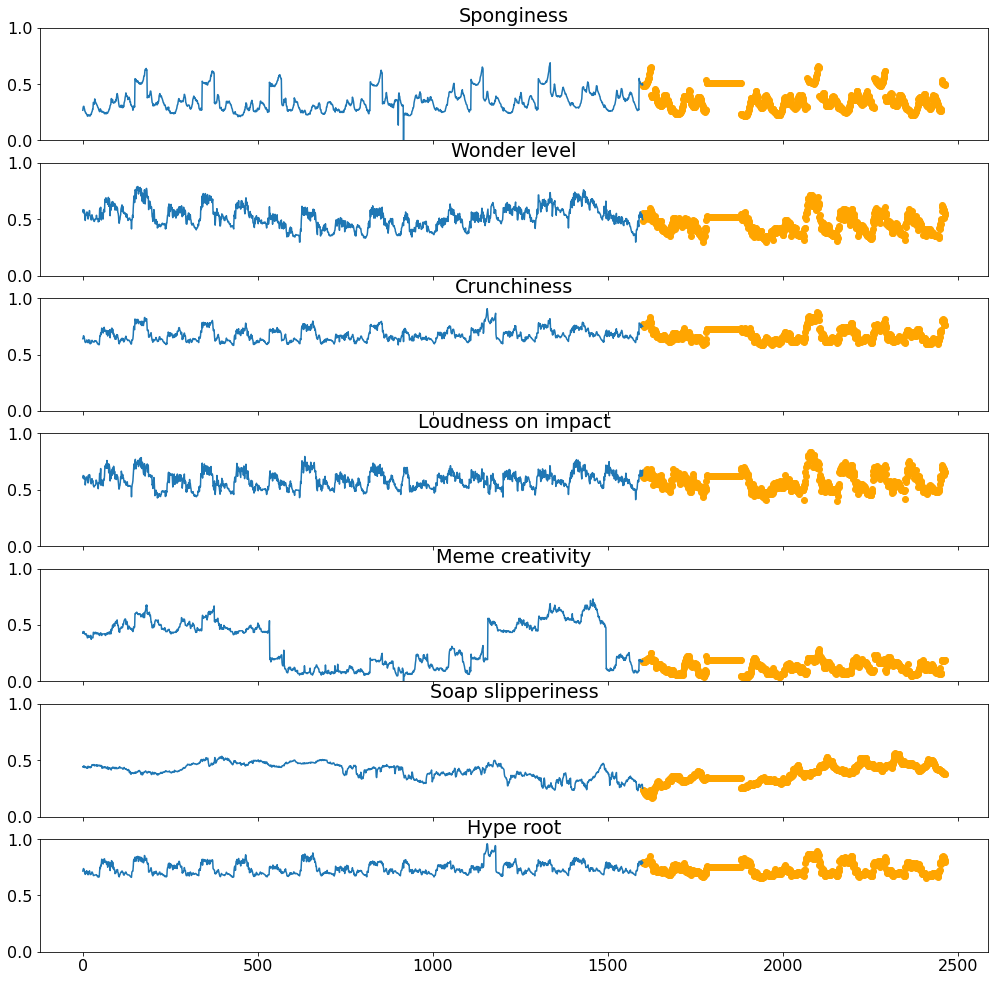

In [14]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [15]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [16]:
def build_Seq2Seq_LSTM_Attention_model(p_input_shape, p_output_shape):
    input_train = tfkl.Input(shape=p_input_shape)
    output_train = tfkl.Input(shape=p_output_shape)

    encoder_stack_h, encoder_last_h, encoder_last_c = tfkl.LSTM(
        120, activation='elu', dropout=0.2, recurrent_dropout=0.2,
        return_state=True, return_sequences=True, kernel_regularizer=tfk.regularizers.l2(
            0.01), recurrent_regularizer=tfk.regularizers.l2(0.01), bias_regularizer=tfk.regularizers.l2(0.01))(input_train)

    encoder_last_h = tfkl.BatchNormalization(momentum=0.6)(encoder_last_h)
    encoder_last_c = tfkl.BatchNormalization(momentum=0.6)(encoder_last_c)

    decoder_input = tfkl.RepeatVector(output_train.shape[1])(encoder_last_h)
    decoder_stack_h = tfkl.LSTM(120, activation='elu', dropout=0.2, recurrent_dropout=0.2,
                                return_state=False, return_sequences=True, kernel_regularizer=tfk.regularizers.l2(
                                    0.01), recurrent_regularizer=tfk.regularizers.l2(0.01), bias_regularizer=tfk.regularizers.l2(0.01))(
        decoder_input, initial_state=[encoder_last_h, encoder_last_c])

    attention = tfkl.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = tfkl.Activation('softmax')(attention)

    context = tfkl.dot([attention, encoder_stack_h], axes=[2, 1])
    context = tfkl.BatchNormalization(momentum=0.6)(context)

    decoder_combined_context = tfkl.concatenate([context, decoder_stack_h])

    out = tfkl.TimeDistributed(tfkl.Dense(output_train.shape[2]))(
        decoder_combined_context)

    built_model = tfk.Model(
        inputs=input_train, outputs=out, name='Seq2Seq_LSTM_with_Attention')

    # Compile the model
    built_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(),
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Return the model
    return built_model

2021-12-23 22:06:27.555488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 22:06:27.645157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 22:06:27.645833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 22:06:27.646897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "Seq2Seq_LSTM_with_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1600, 7)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1600, 120),  61440       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 120)          480         lstm[0][1]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 864, 120)     0           batch_normalization[0][0]        
________________________________________________________________________

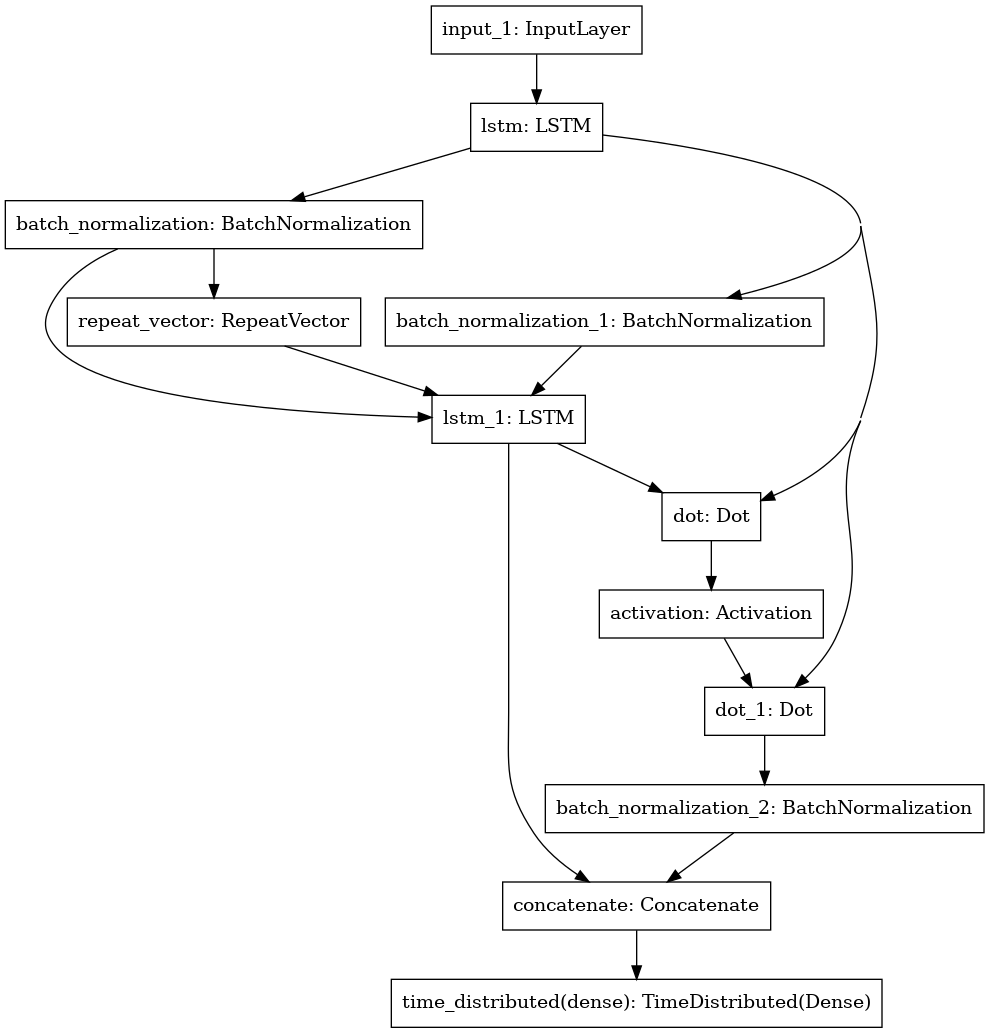

In [17]:
model = build_Seq2Seq_LSTM_Attention_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [18]:
# Train the model
callbacks = create_folders_and_callbacks(model_name='Seq2Seq_LSTM_with_Attention')

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=callbacks
).history

2021-12-23 22:06:31.205961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
10/10 [==============================] - 107s 10s/step - loss: 6.8315 - root_mean_squared_error: 0.5591 - val_loss: 6.3273 - val_root_mean_squared_error: 0.4838


2021-12-23 22:08:20.711429: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/200
10/10 [==============================] - 99s 10s/step - loss: 5.9186 - root_mean_squared_error: 0.3152 - val_loss: 5.5274 - val_root_mean_squared_error: 0.2889
Epoch 3/200
10/10 [==============================] - 98s 10s/step - loss: 5.2515 - root_mean_squared_error: 0.2439 - val_loss: 4.8962 - val_root_mean_squared_error: 0.1951
Epoch 4/200
10/10 [==============================] - 100s 10s/step - loss: 4.6833 - root_mean_squared_error: 0.2016 - val_loss: 4.4088 - val_root_mean_squared_error: 0.2206
Epoch 5/200
10/10 [==============================] - 99s 10s/step - loss: 4.2117 - root_mean_squared_error: 0.1761 - val_loss: 3.9751 - val_root_mean_squared_error: 0.1678
Epoch 6/200
10/10 [==============================] - 99s 10s/step - loss: 3.8248 - root_mean_squared_error: 0.1602 - val_loss: 3.6354 - val_root_mean_squared_error: 0.1704
Epoch 7/200
10/10 [==============================] - 99s 10s/step - loss: 3.5067 - root_mean_squared_error: 0.1495 - val_loss: 3.3527 - val

In [19]:
model.save('Seq2Seq_LSTM_with_Attention')
# model = tfk.models.load_model('Seq2Seq_LSTM_with_Attention')

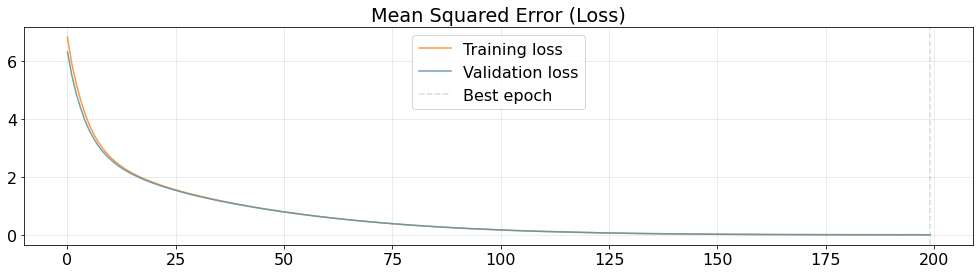

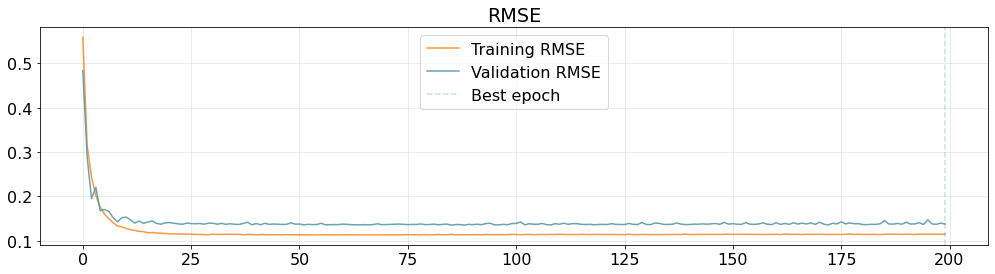

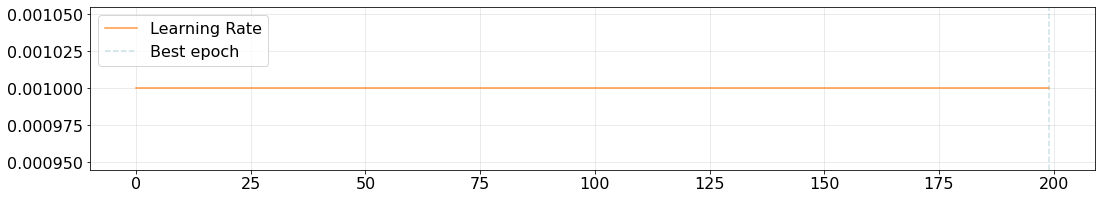

In [20]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17, 4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17, 4))
plt.plot(history['root_mean_squared_error'], label='Training RMSE', alpha=.8, color='#ff7f0e')
plt.plot(history['val_root_mean_squared_error'], label='Validation RMSE', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('RMSE')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()